# Loop over multiple SIR 3S calculations

SIR 3S provides a C# .NET adapter for carrying out loops over multiple calculations. With the C# .NET adapter, SIR 3S calculations can be integrated directly into other software. In SIR 3S itself, the C# .NET adapter is used to implement calculation loops such as n-1 calculations.

In addition, SIR 3S provides connections to control systems via OPC and other interfaces such as Kafka. The SIR 3S software component for these connections is called - for historical reasons - SirOPC. SirOPC is used for in-process SIR 3S simulations such as cyclic look-ahead calculations.

SIR 3S also offers the option to perform several steady state calculations one after the other in one SIR 3S calculation run as quasi steady state calculations. The sequence of calculations is done out over a pseudo time step, e.g. 1 hour with 60 calculations or 1 year with 8760 calculations. Whether individual calculations or a sequence over a pseudo-time in one run is the better choice depends on the task.

Despite the aforementioned options, it can be helpful to control or perform SIR 3S calculations calculations by script.

This script serves as an example for a loop over several SIR 3S calculations.

# PT3S Release

In [1]:
#pip install PT3S -U --no-deps

# Imports

In [2]:
import os
import geopandas
import logging
import pandas as pd
import io
import subprocess
#from PIL import Image


import matplotlib.pyplot as plt
#import matplotlib.dates as mdates

import matplotlib

import folium
from folium.plugins import HeatMap

import networkx as nx

try:
    from PT3S import dxAndMxHelperFcts
except:
    import dxAndMxHelperFcts
    
try:
    from PT3S import Mx
except:
    import Mx

try:
    from PT3S import Rm
except:
    import Rm
    
    
try:
    from PT3S import pNFD
except:
    import pNFD

In [3]:
import importlib

In [4]:
#importlib.reload(dxAndMxHelperFcts)

# Logging

In [5]:
logger = logging.getLogger()  

logFileName= r"Example5.log" 

loglevel = logging.DEBUG
logging.basicConfig(filename=logFileName
                        ,filemode='w'
                        ,level=loglevel
                        ,format="%(asctime)s ; %(name)-60s ; %(levelname)-7s ; %(message)s")    

fileHandler = logging.FileHandler(logFileName)     

logger.addHandler(fileHandler)

consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(logging.Formatter("%(levelname)-7s ; %(message)s"))
consoleHandler.setLevel(logging.INFO)
logger.addHandler(consoleHandler)

# Read Model and Results

In [6]:
dbFilename="Example5"
dbFile=os.path.join(os.path.dirname(os.path.abspath(dxAndMxHelperFcts.__file__))
                    +'/Examples/'
                    +dbFilename
                    +'.db3'
)

In [7]:
m=dxAndMxHelperFcts.readDxAndMx(dbFile=dbFile,preventPklDump=True,maxRecords=-1)

INFO    ; Dx.__init__: dbFile (abspath): c:\users\aUserName\3s\pt3s\Examples\Example5.db3 exists readable ...
INFO    ; dxAndMxHelperFcts.readDxAndMx: running C:\\3S\Sir3s\SirCalc-90-14-02-10_Potsdam\SirCalc.exe ...
INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...
INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


# Plot Result 

In [8]:
def plot_Result(gdf_ROHR, gdf_FWVB,axTitle='initial condition'):
    fig=plt.figure(figsize=Rm.DINA2q,dpi=Rm.dpiSize)

    ax=fig.gca()

    attr_colors_ROHR_Sach_patches,attr_colors_ROHR_Erg_patches,attr_colors_FWVB_Sach_patches,attr_colors_FWVB_Erg_patches,attr_colors_KNOT_Erg_patches=pNFD.pNFD_FW(
        ax=ax

        ,axTitle=axTitle

        ,gdf_ROHR = gdf_ROHR[gdf_ROHR['KVR'].isin([1])].sort_values(by=['QMAVAbs'],ascending=True)    
        
        ,fac_lws_ROHR=15. 
       
        
        #,attr_colors_ROHR_Erg=ergCol_ROHR
        ,lws_ROHR_Erg_Sach=False   
        
        ,norm_max_ROHR_Erg = 800.      
    
    
        ,gdf_FWVB=gdf_FWVB
        

    )
    plt.show()
    

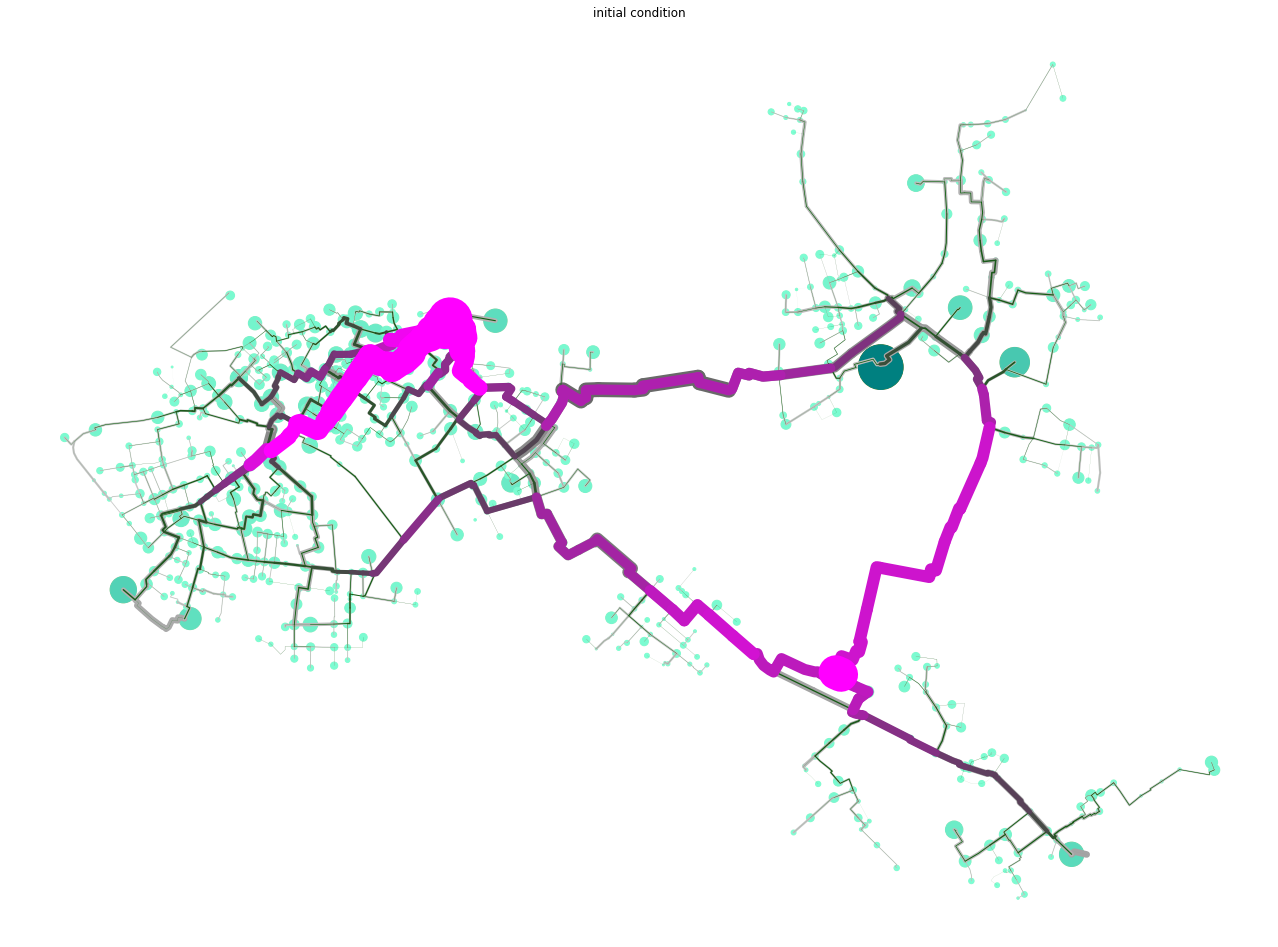

In [9]:
plot_Result(m.gdf_ROHR, m.gdf_FWVB)

# Show Network Graph

In [10]:
netNodes=[n for (n,data) in m.G.nodes(data=True) if data['ID_CONT']==data['IDPARENT_CONT']] # nur das Netz

In [11]:
GNet=m.G.subgraph(netNodes)

In [12]:
nx.number_connected_components(GNet)

1

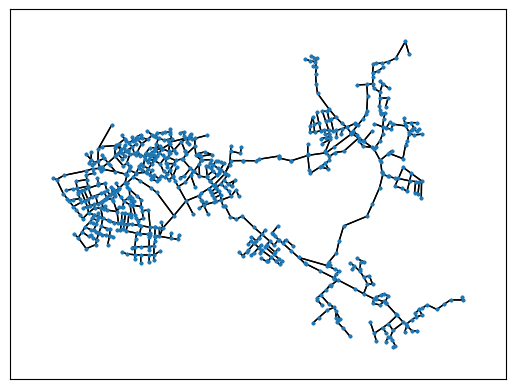

In [13]:
nx.draw_networkx(GNet,with_labels = False,node_size=3,pos=m.nodeposDctNx)

# Decomposition into Areas

In the network, areas can be separated by  valves in the sense of an emergency concept. 
In this way, leaks can be isolated while maintaining supply in the other areas.
All seperating valves are located in the SIR 3S Block "TS".
So the network graph without the content of "TS" must be decomposed into areas.

In [14]:
netEdgesWithoutTS=[(i,k) for i,k,data in GNet.edges(data=True) if data['NAME_CONT'] not in ['TS']] 

In [15]:
GNetWithoutTS=GNet.edge_subgraph(netEdgesWithoutTS)

In [16]:
nOfCC=nx.number_connected_components(GNetWithoutTS)
nOfCC

25

In [17]:
GNetWithoutTSAreas=[GNet.subgraph(c).copy() for c in sorted(nx.connected_components(GNetWithoutTS), key=len, reverse=True)]

# Read SirCalc's XmlFile

In [18]:
import xml.etree.ElementTree as ET
tree = ET.parse(m.SirCalcXmlFile) # ElementTree                 
root = tree.getroot()  # Element

# Loop over all Areas

INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


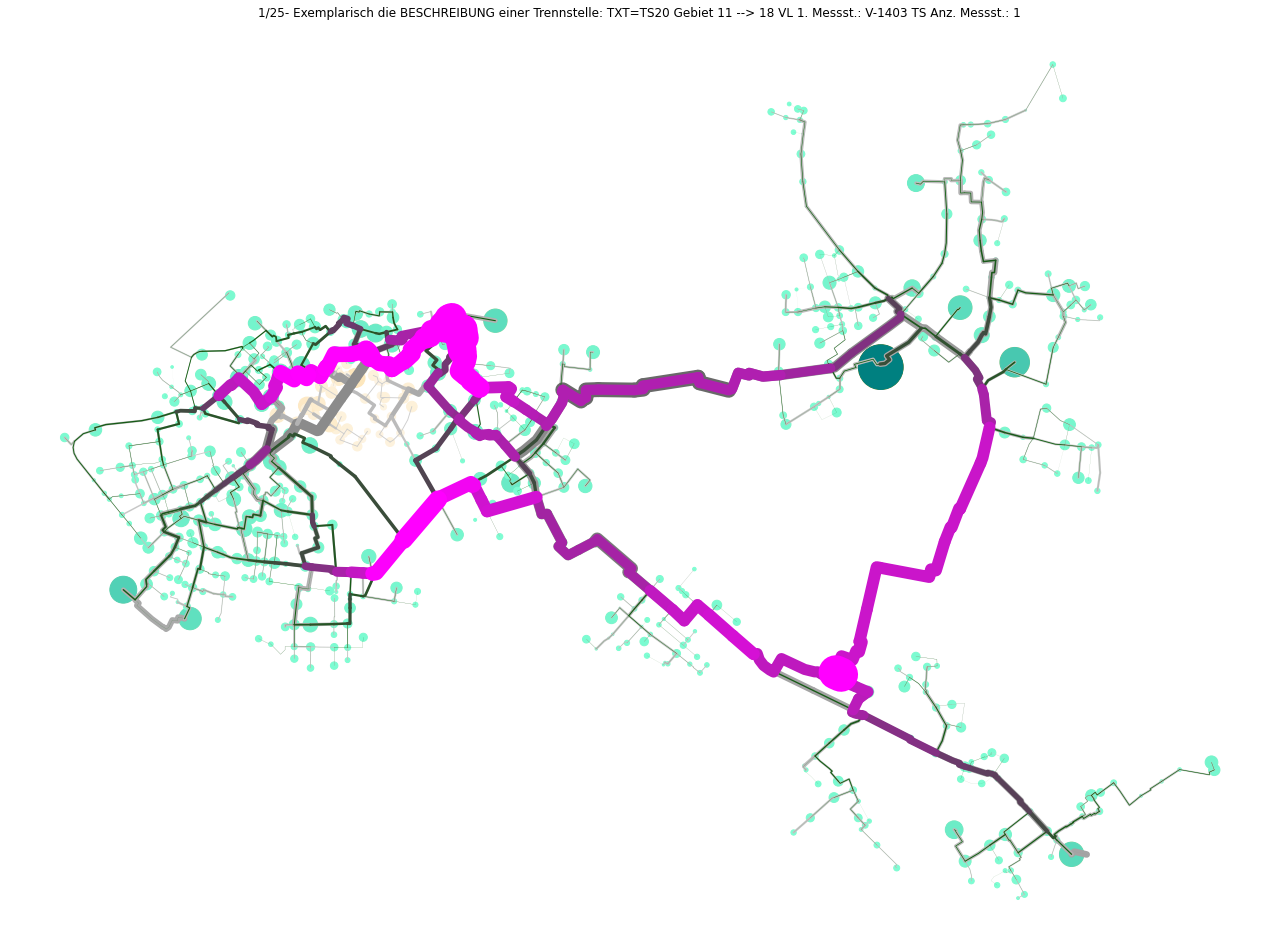

INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


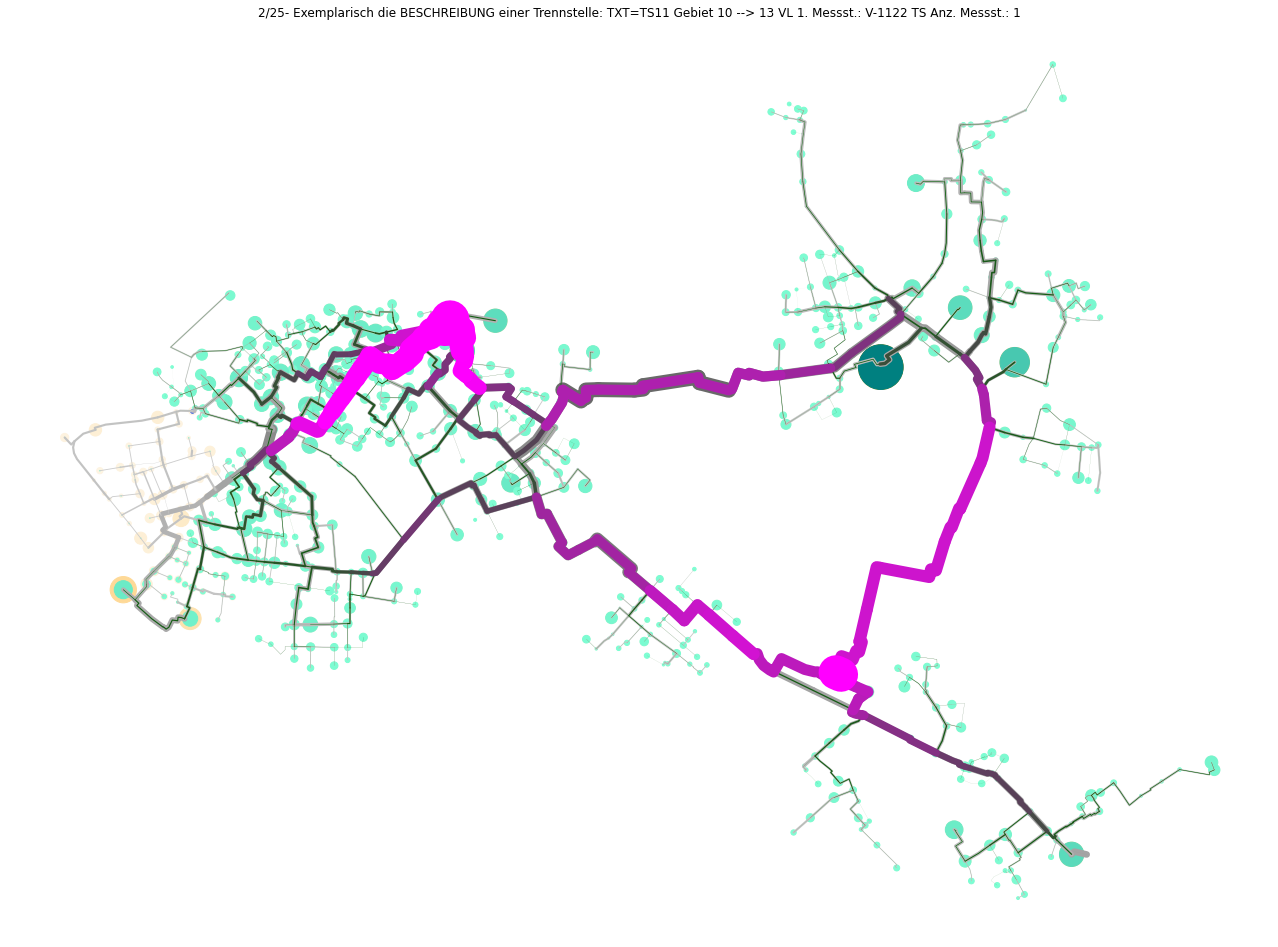

INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


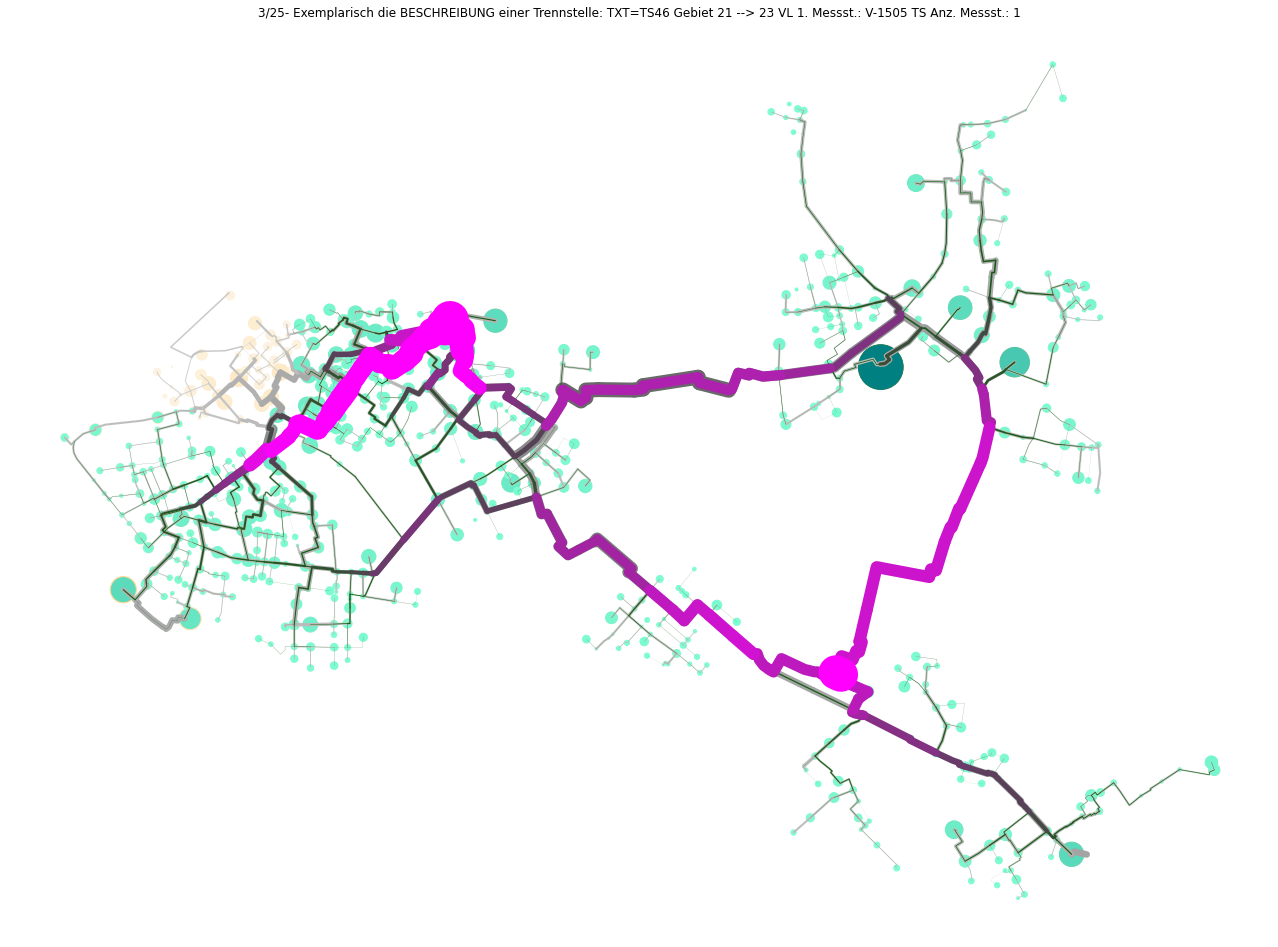

Gebiet um Erzeuger H - keine Trennung


INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


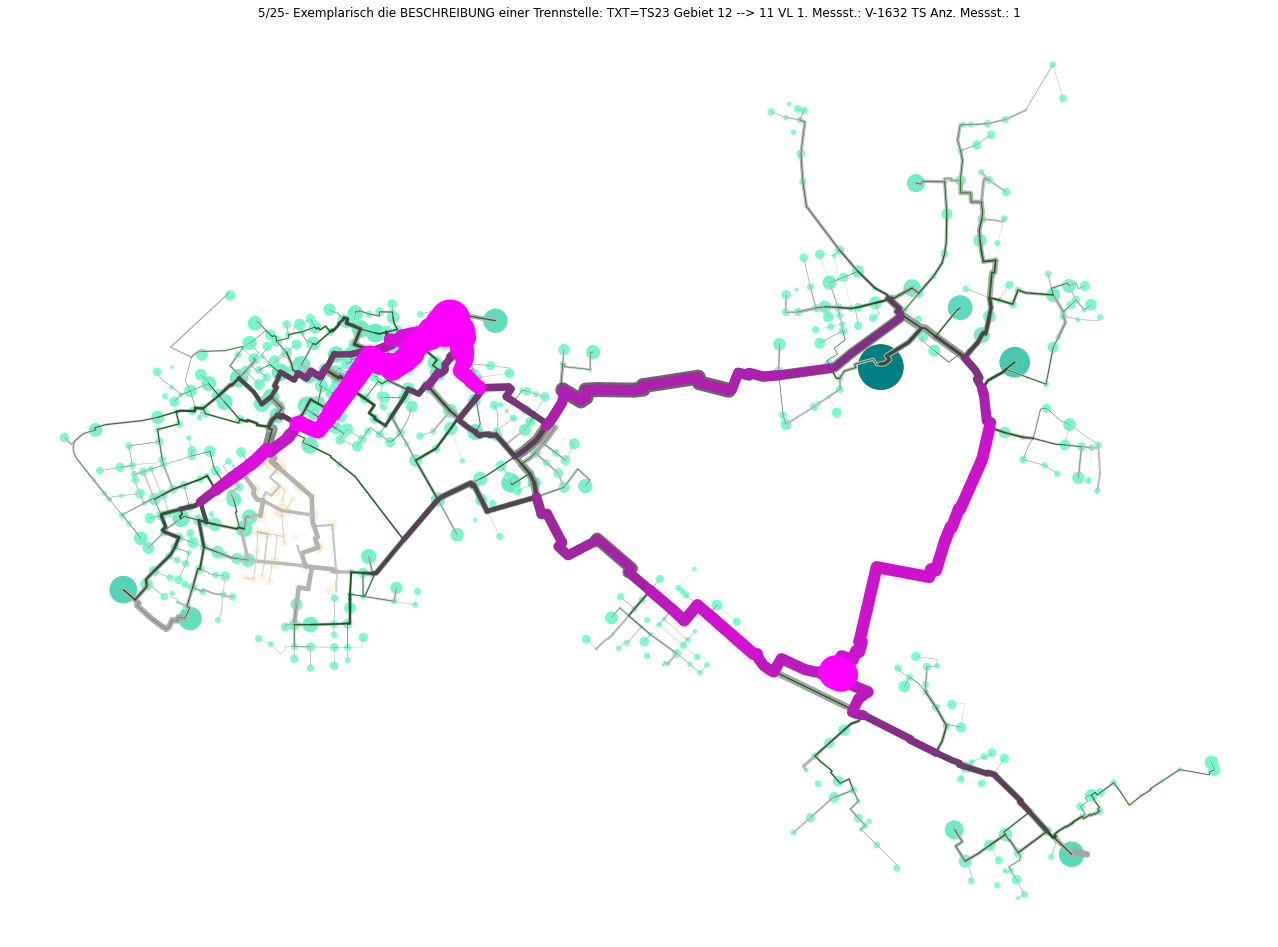

INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


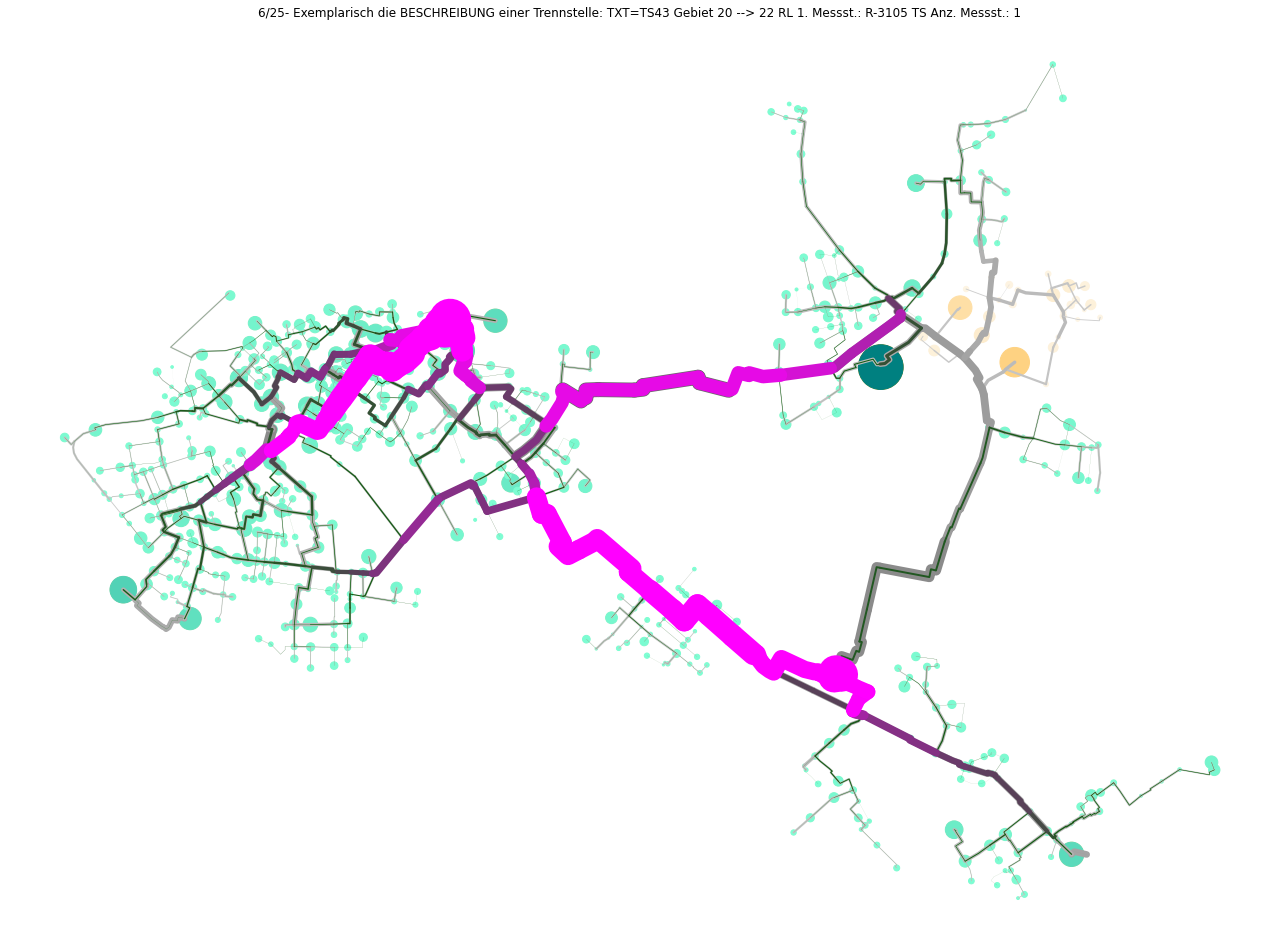

Gebiet um Erzeuger H - keine Trennung


INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


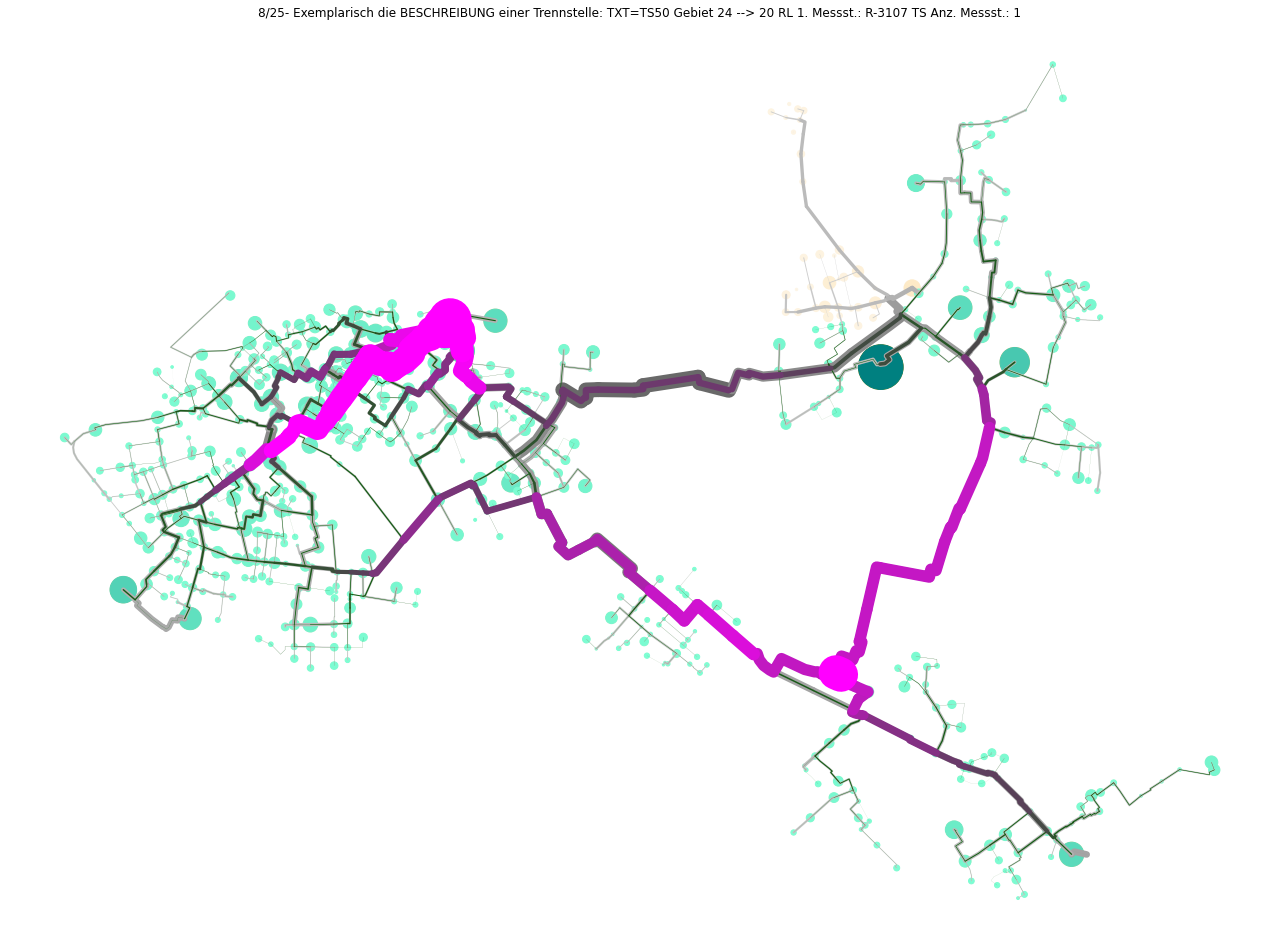

INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


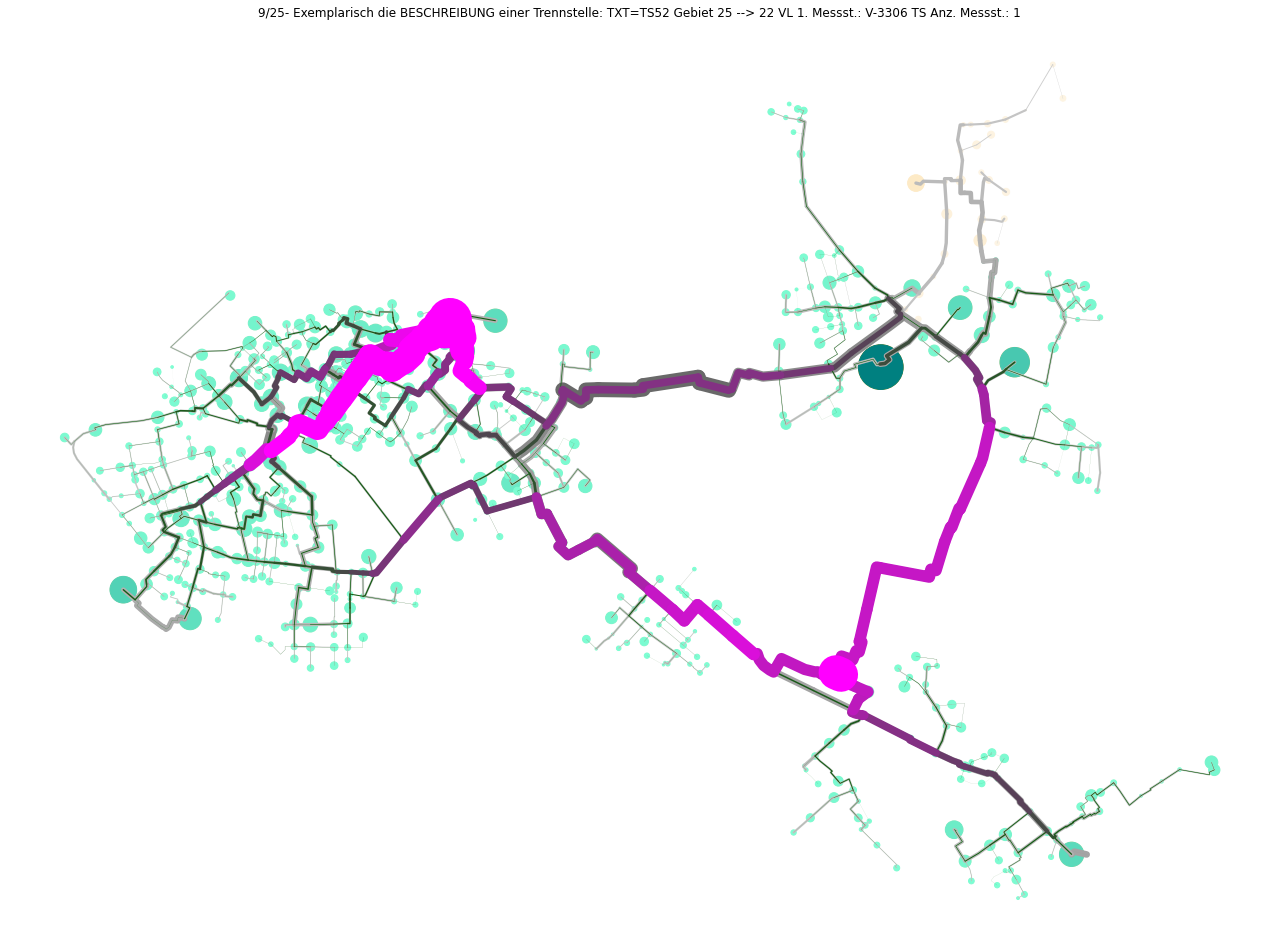

INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


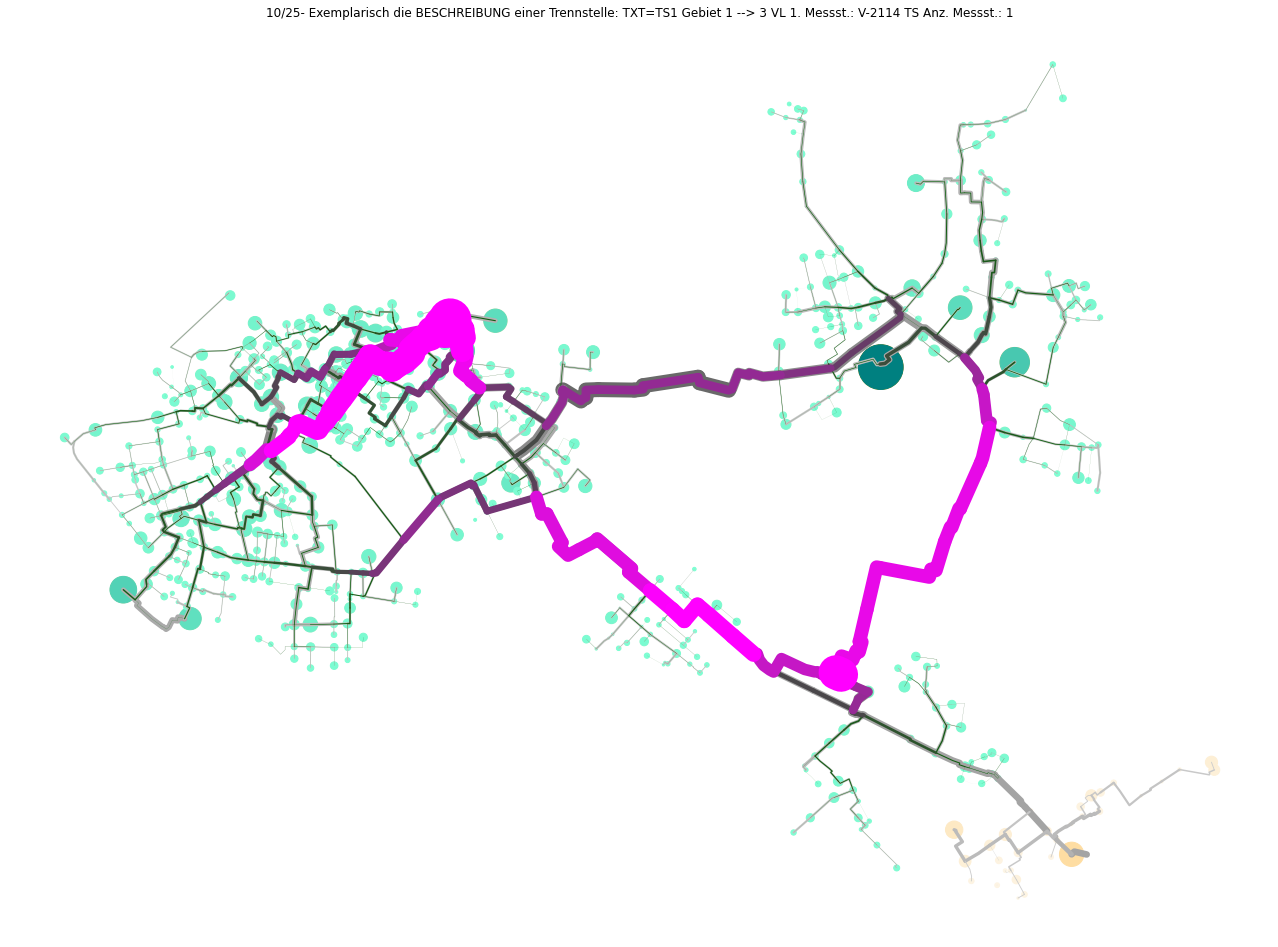

INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


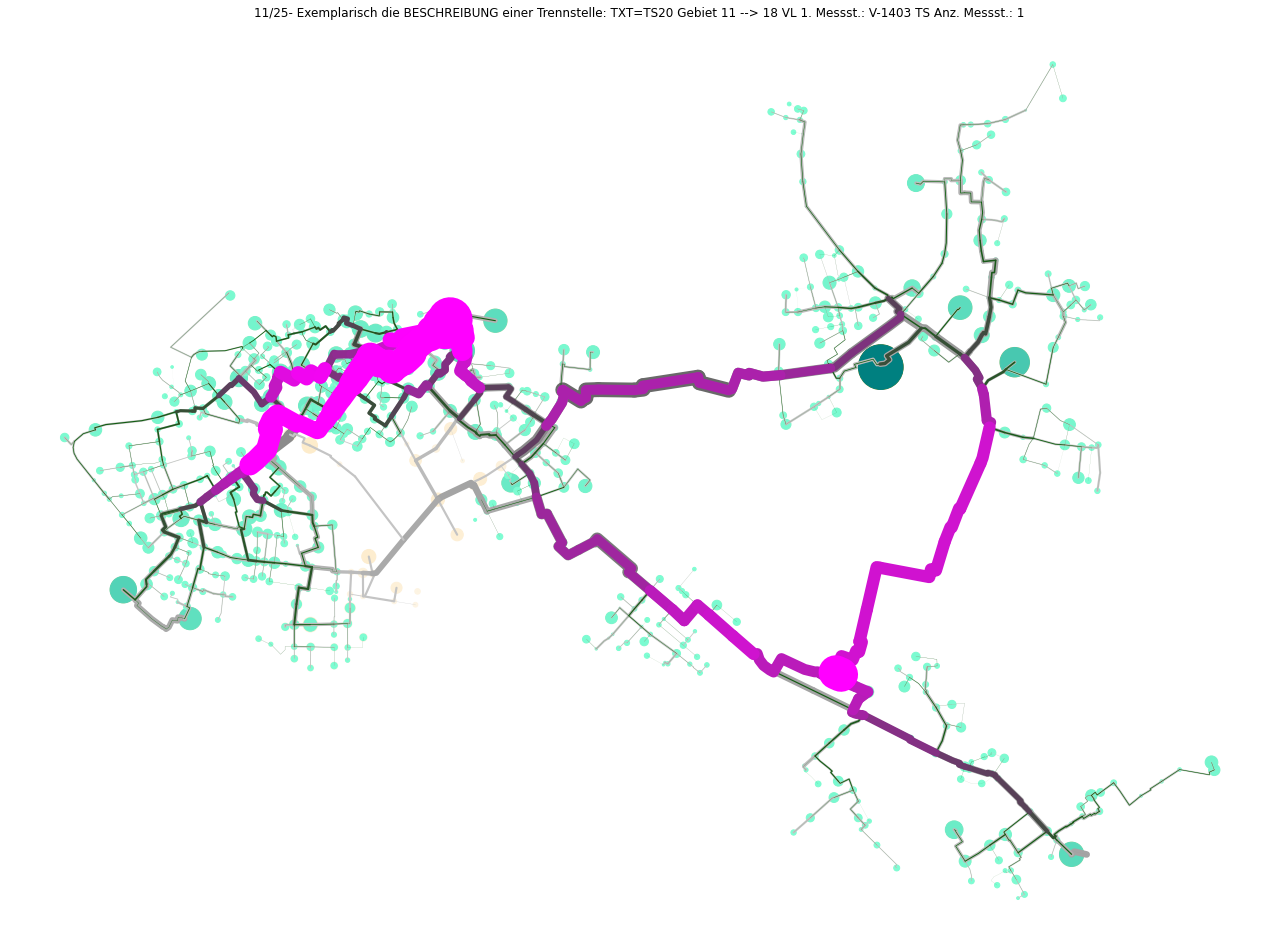

INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


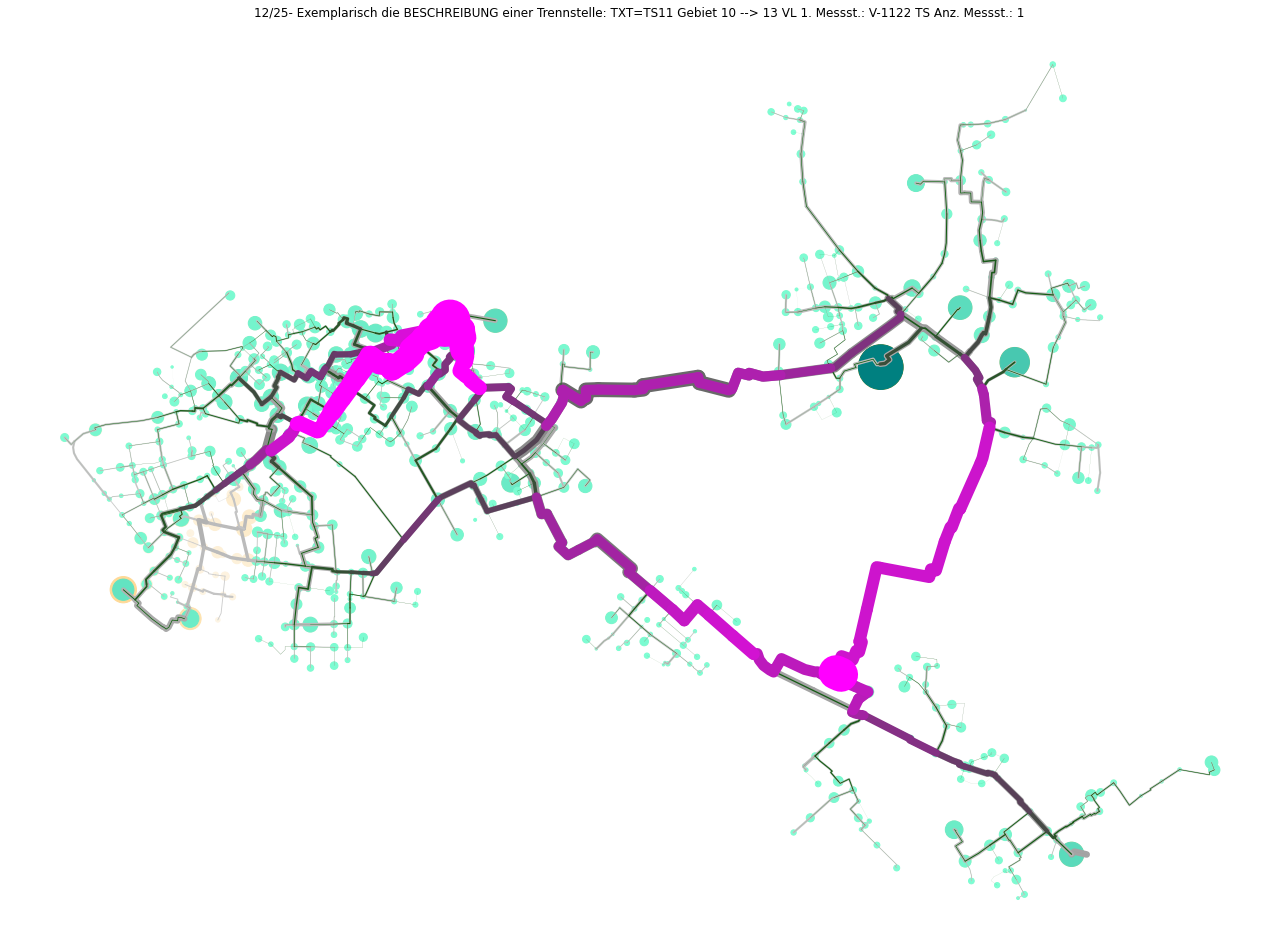

INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


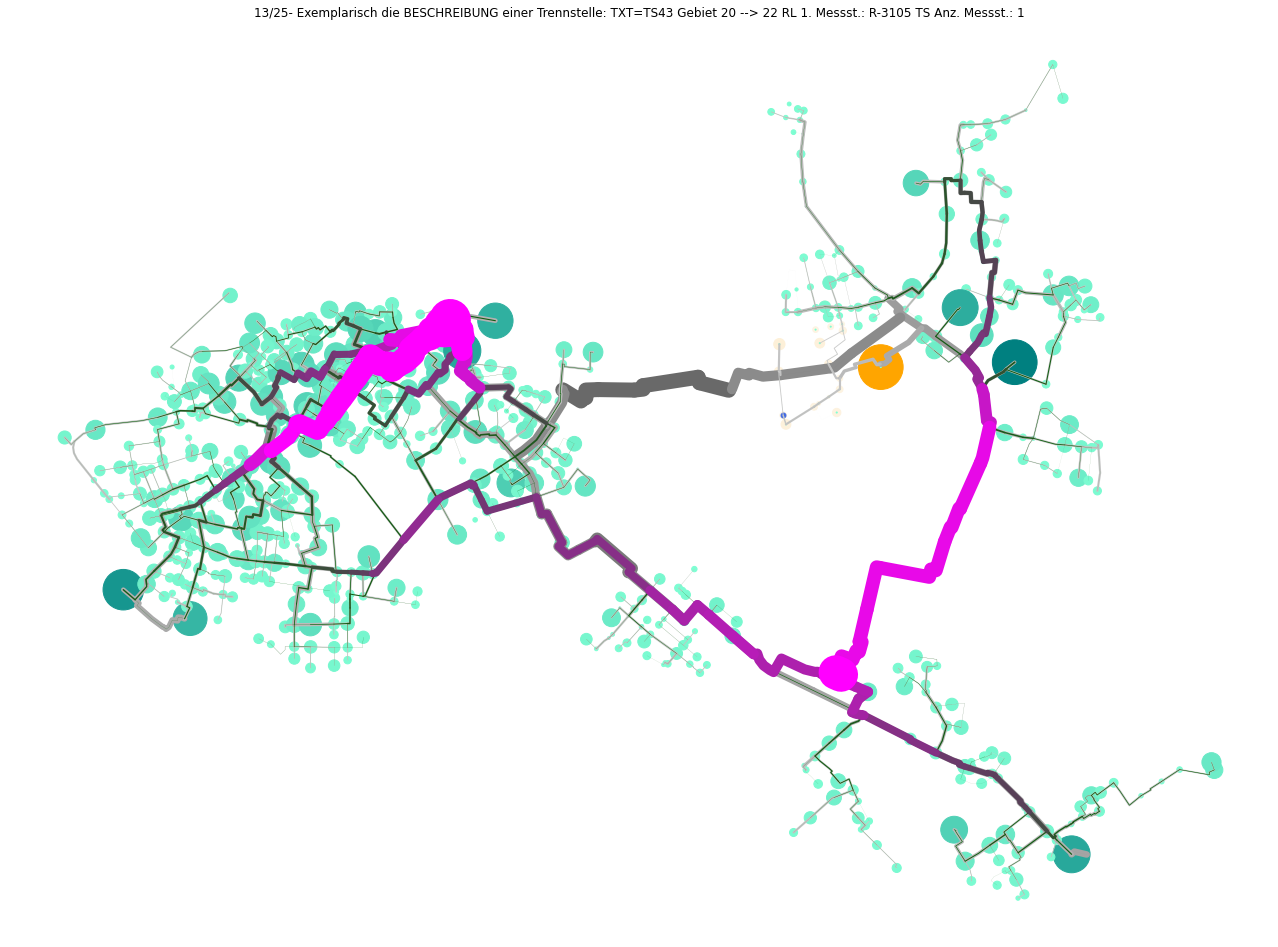

INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


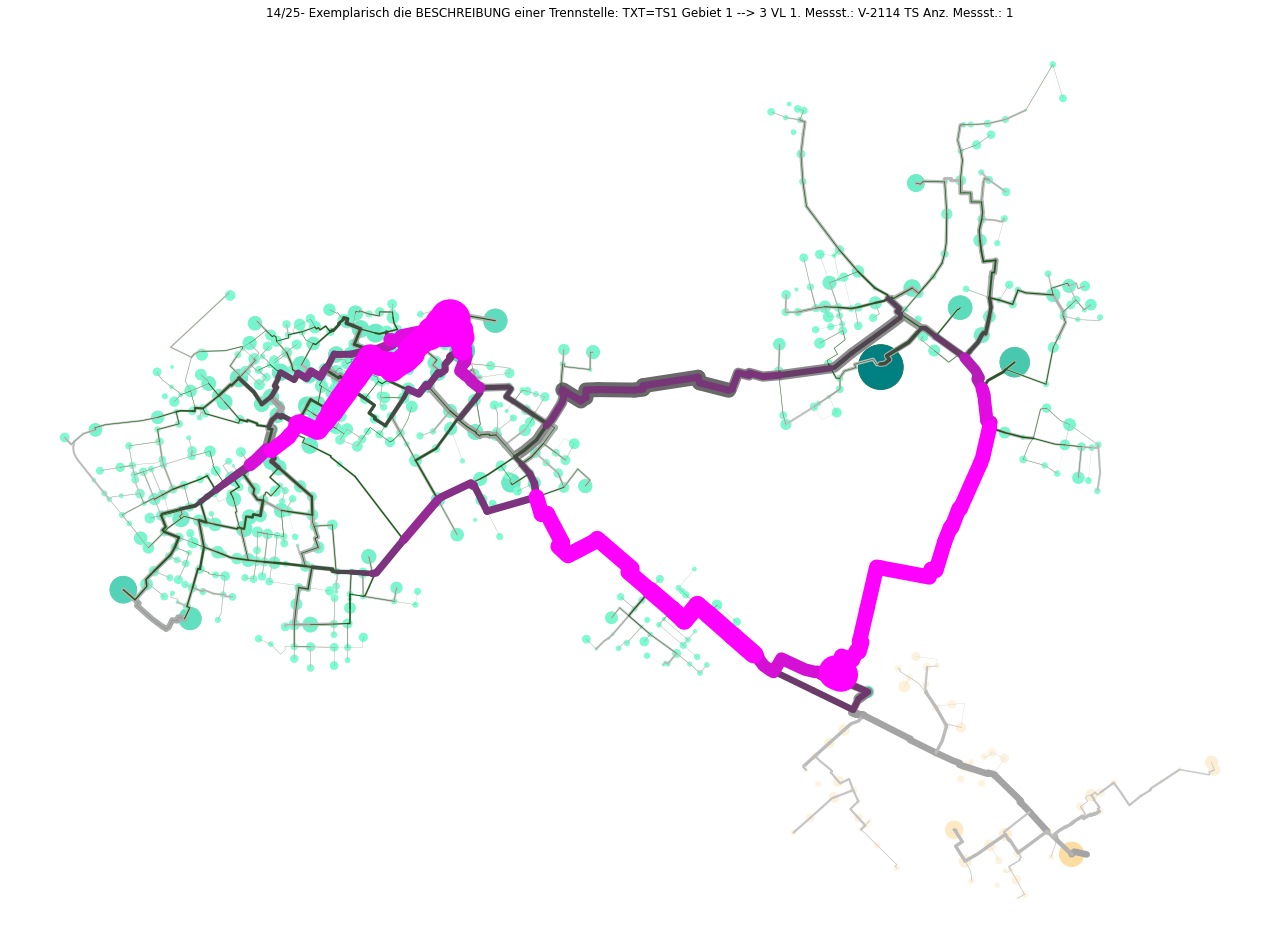

INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


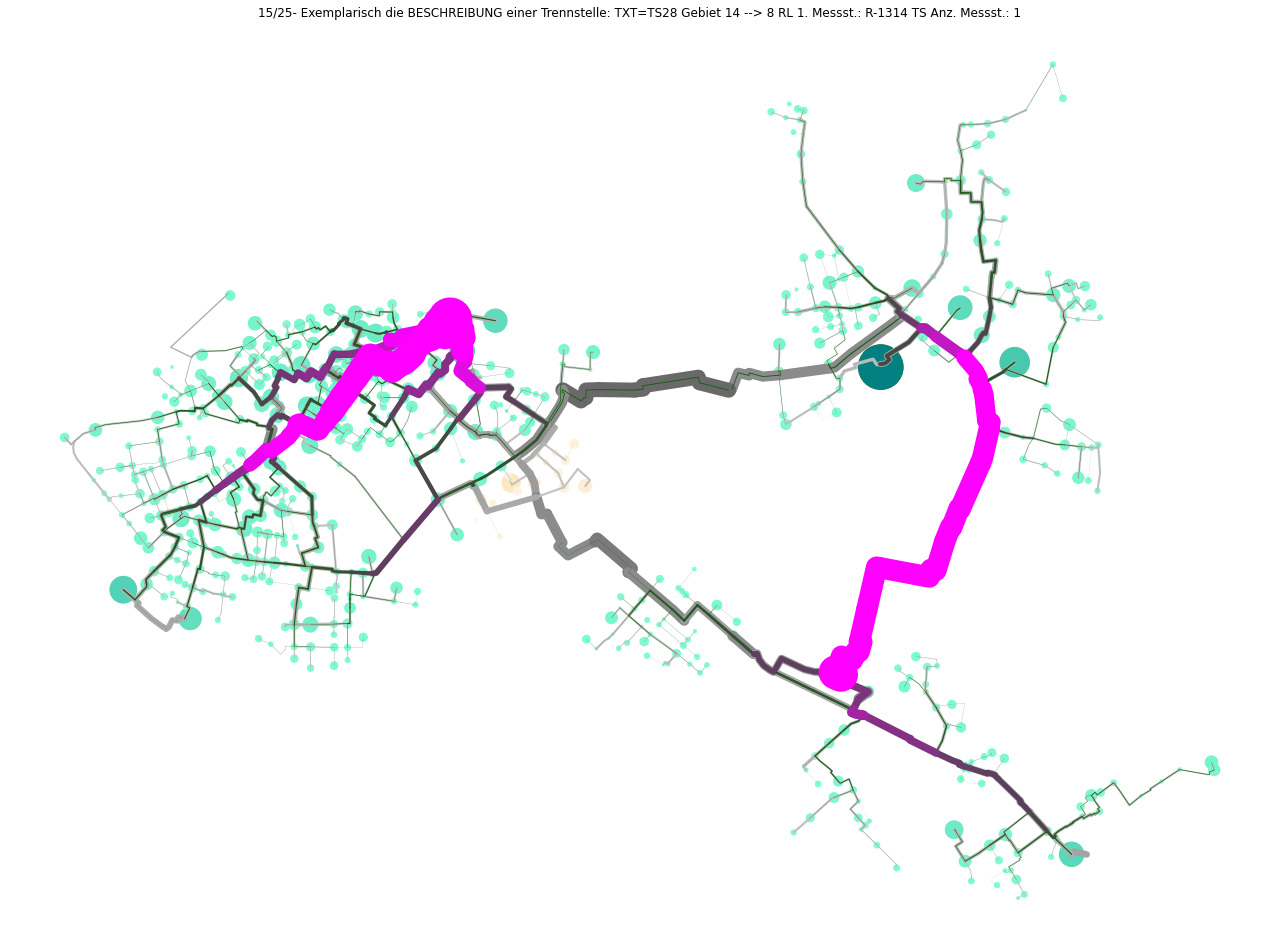

INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


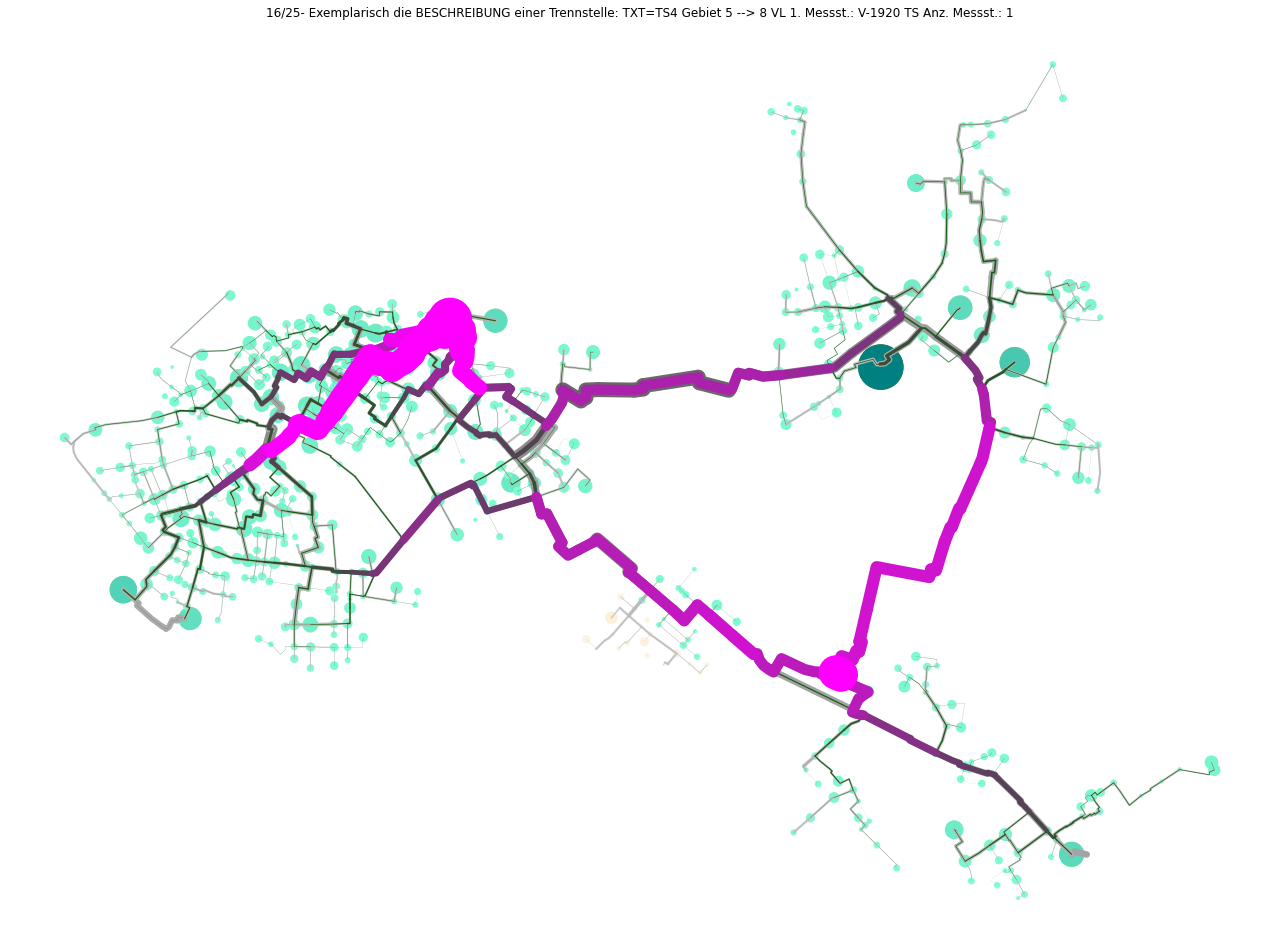

INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


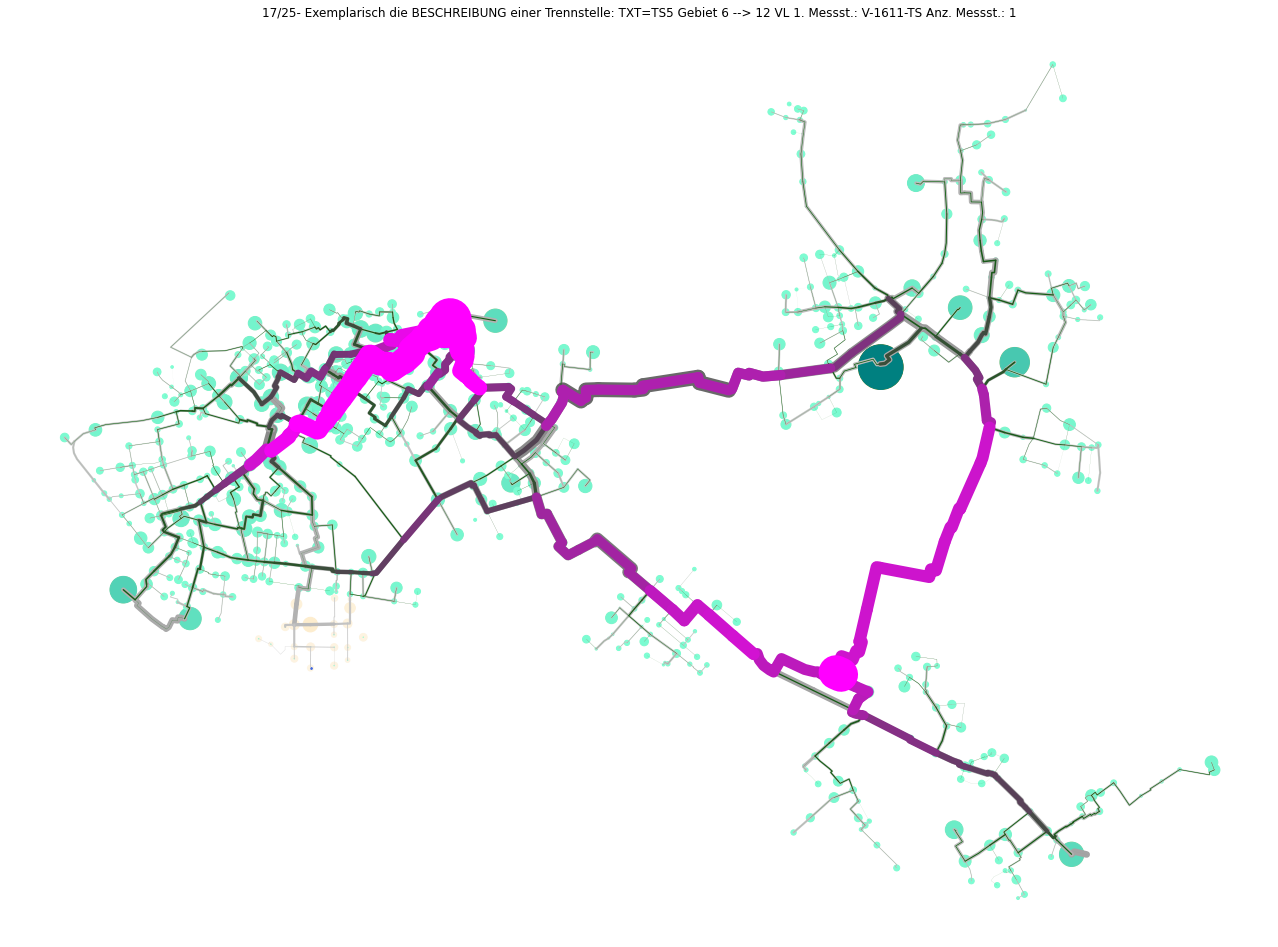

Gebiet um Erzeuger R - keine Trennung


INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


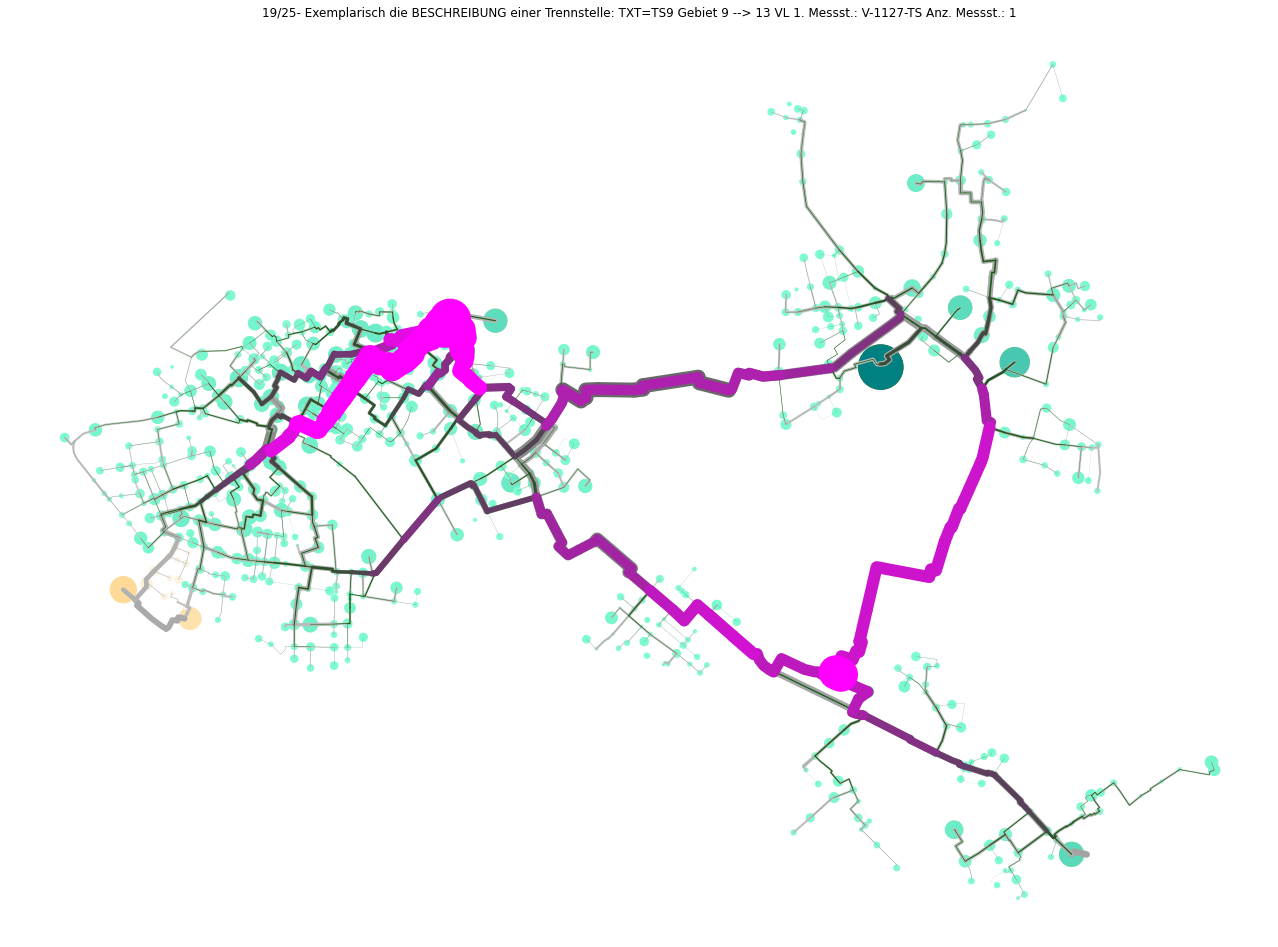

INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


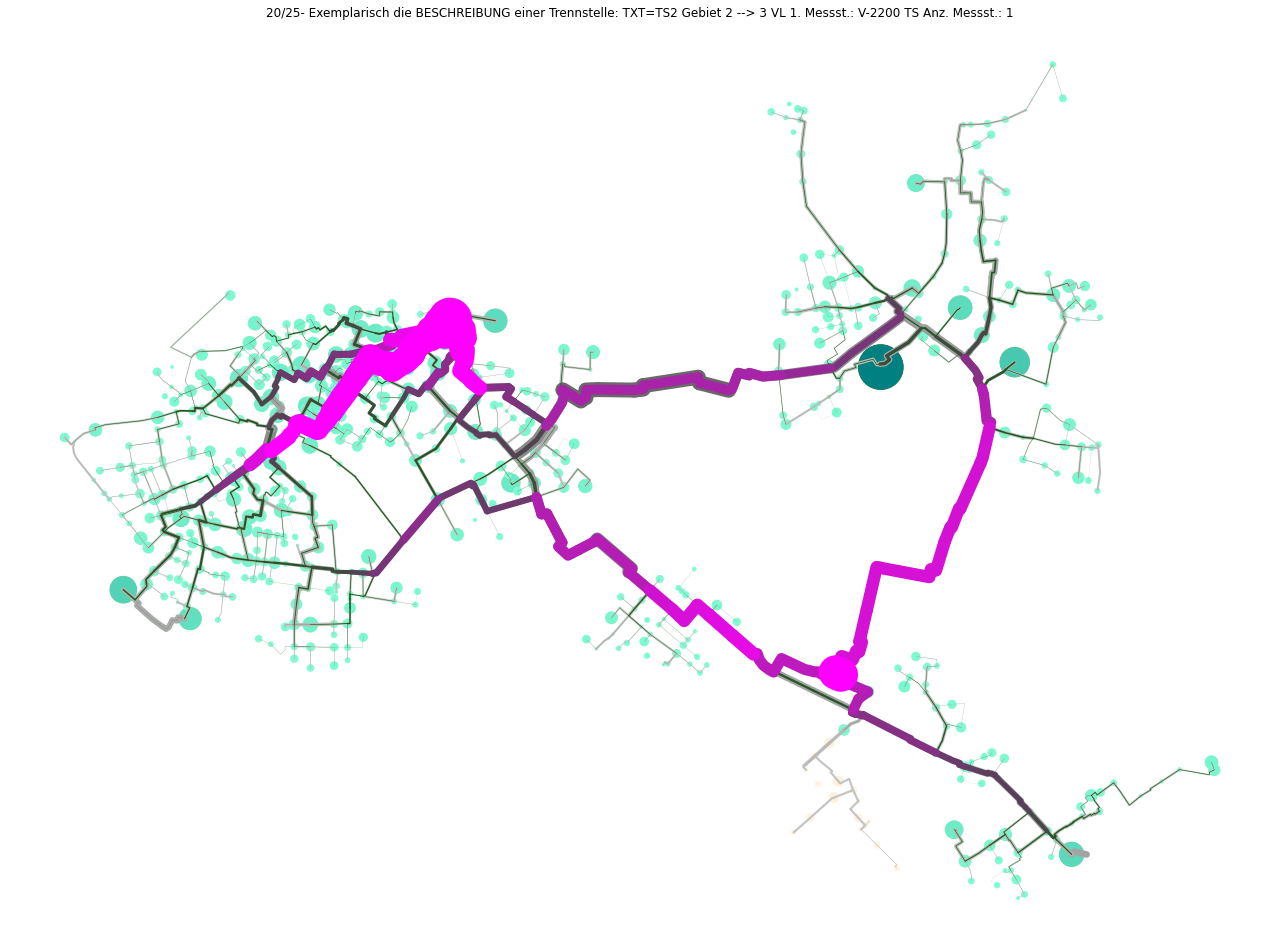

INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


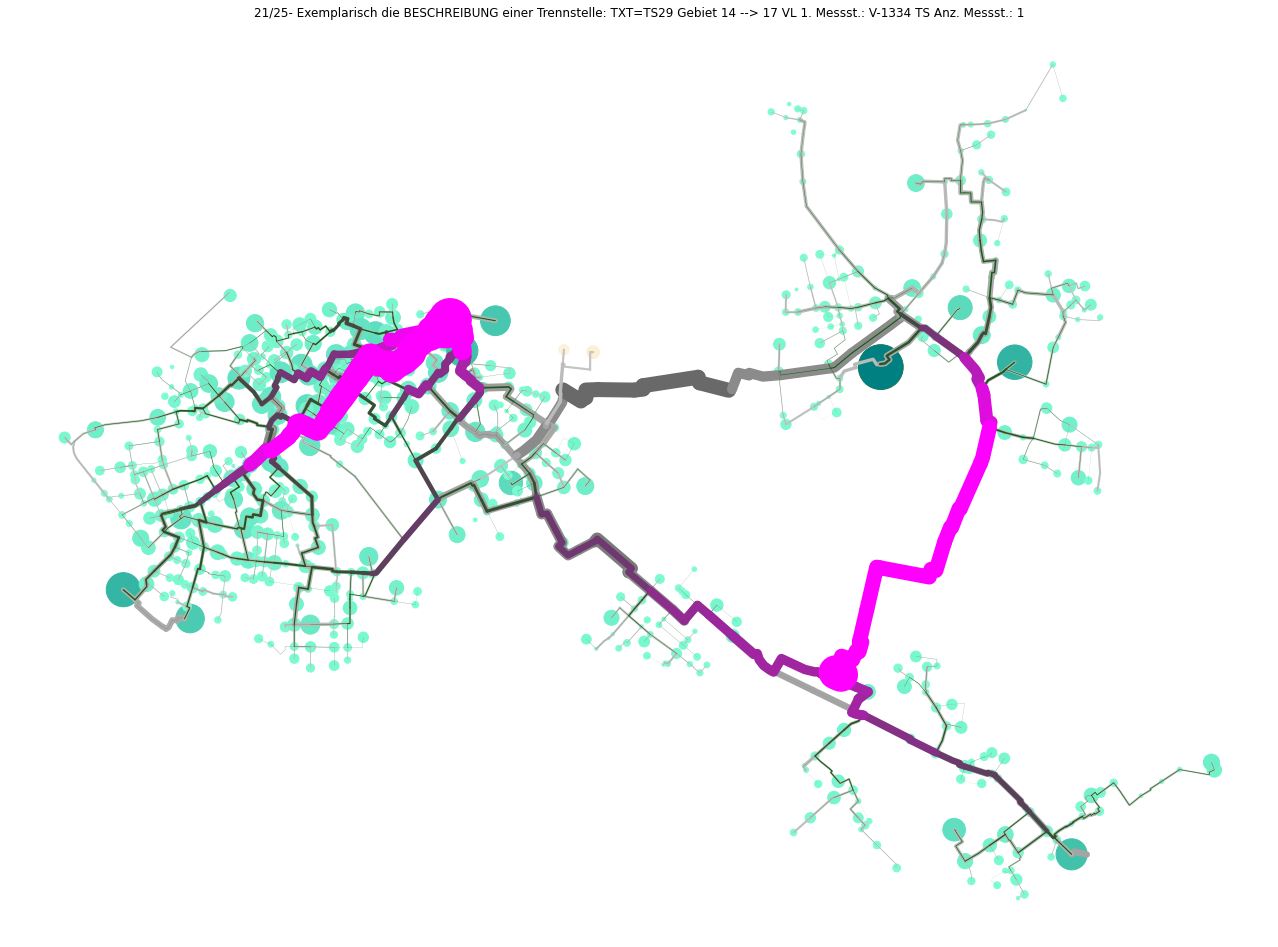

INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


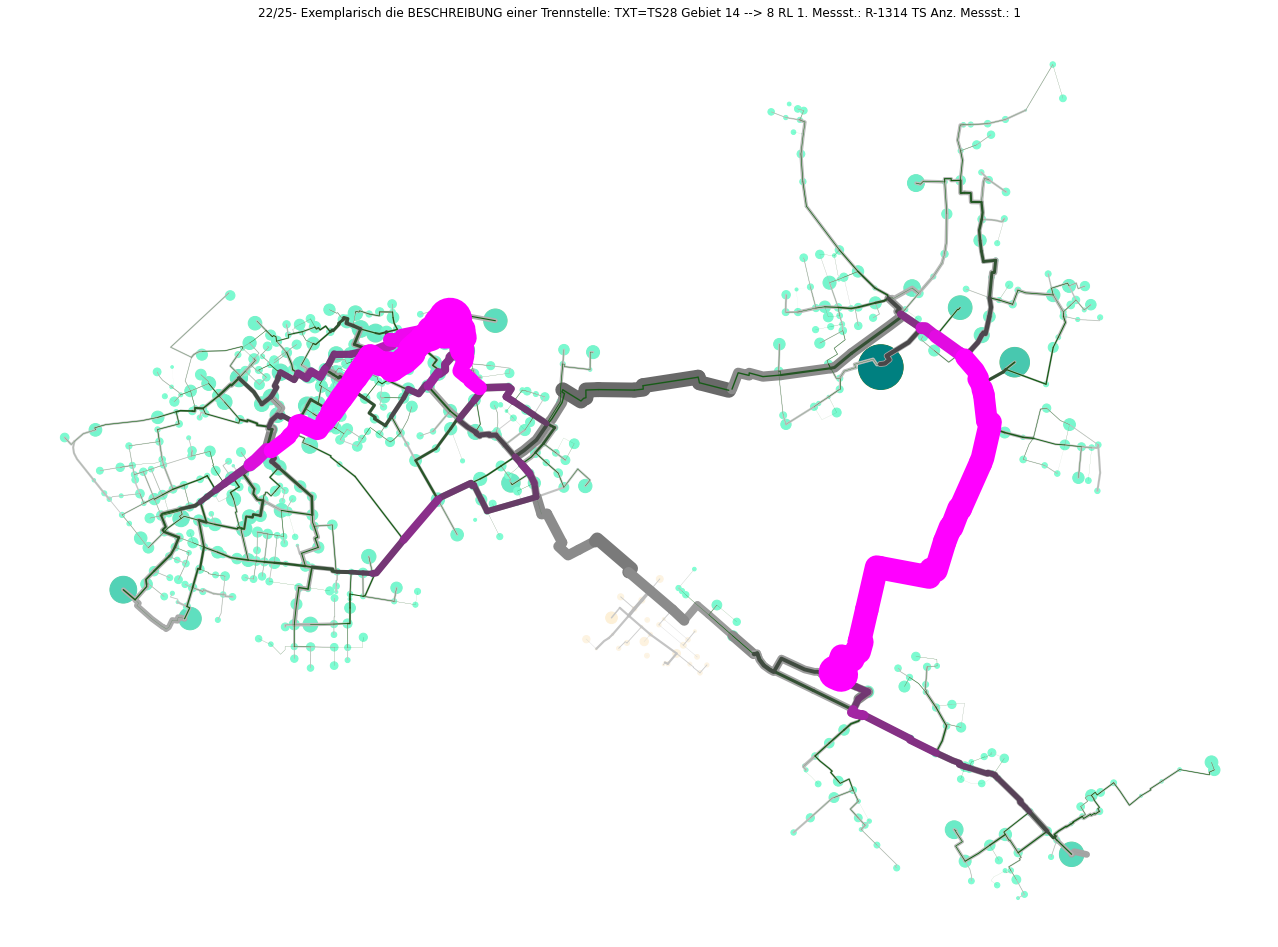

INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


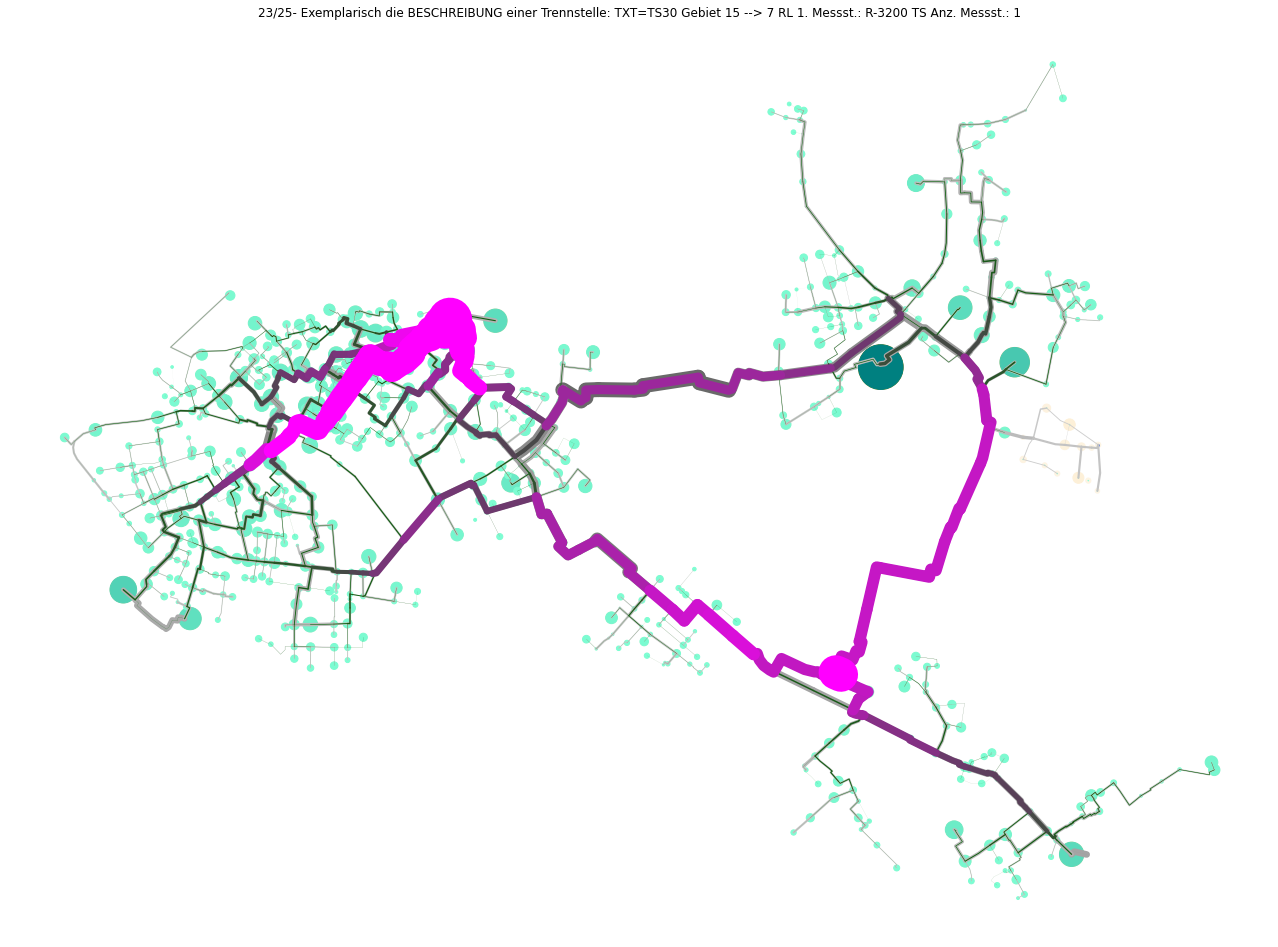

INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


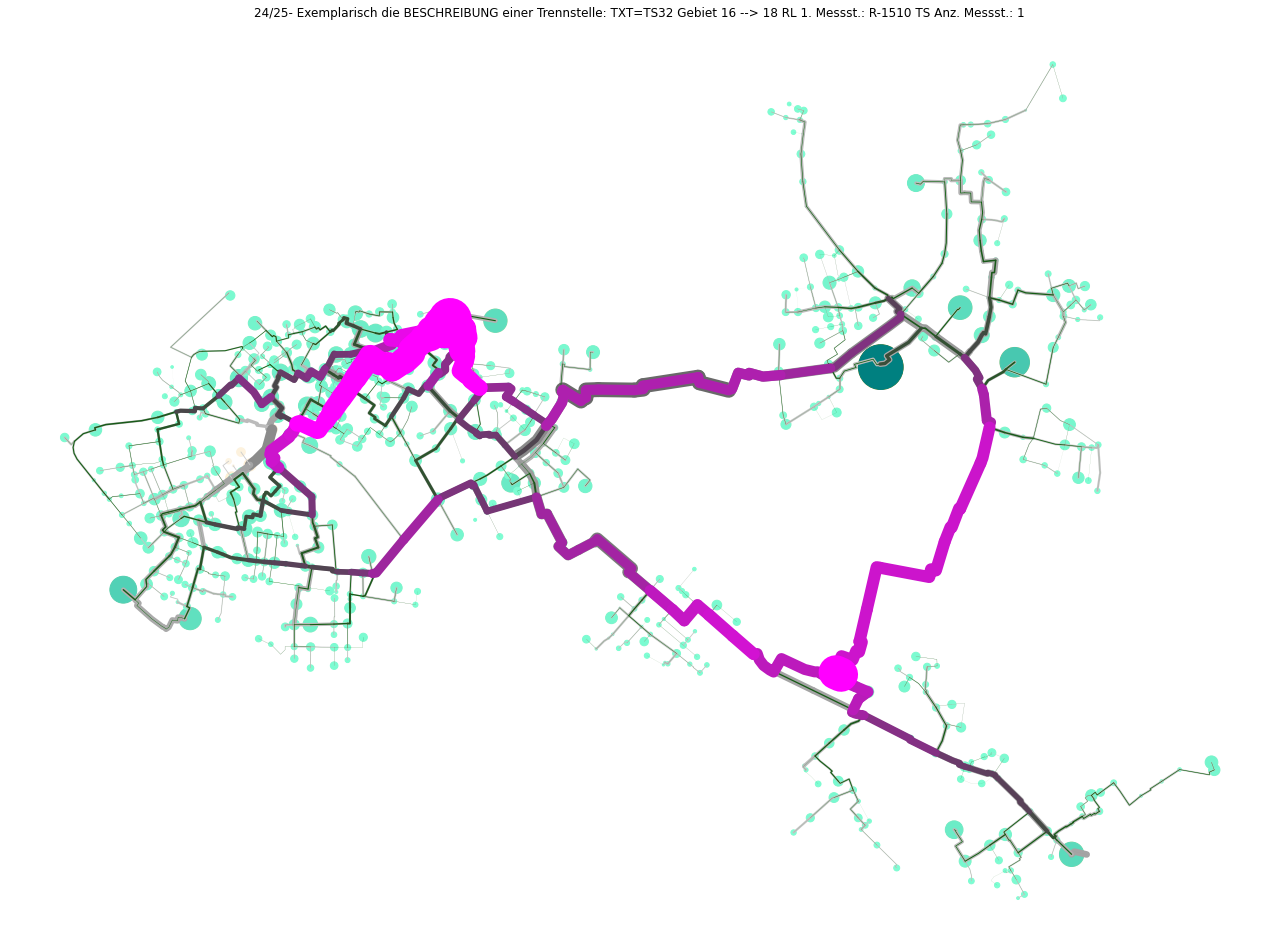

INFO    ; Mx.setResultsToMxsFile: Mxs: ..\Examples\WDExample5\B1\V0\BZ1\M-1-0-1.1.MXS reading ...


Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.


INFO    ; dxWithMx.__init__: Example5: processing dx and mx ...


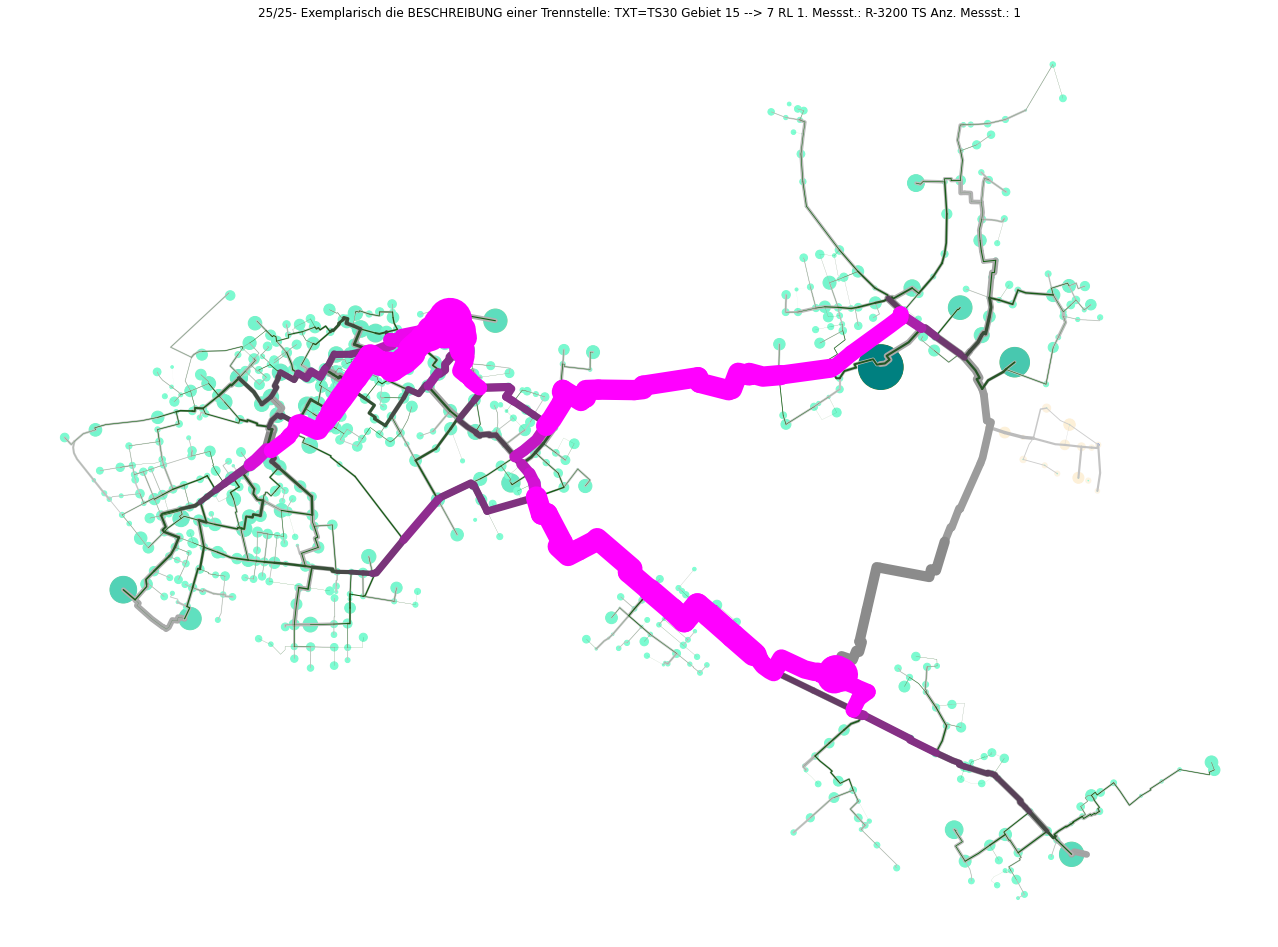

In [19]:
for idx,G in enumerate(GNetWithoutTSAreas):
        
    # Determine seperating Valves to close
    trennNodes=[]
    for n, data in G.nodes(data=True):
        if data['NAME_CONT_VKNO']=='TS':
            trennNodes.append(n)            
    
    trennNodes=sorted(trennNodes)
    
    #print(sorted(G.nodes))
    
    if 'V-A1' in G.nodes:
        print("Gebiet um Erzeuger H - keine Trennung")
        continue
        
    if 'V-A2' in G.nodes:
        print("Gebiet um Erzeuger H - keine Trennung")
        continue
        
    if 'V-B' in G.nodes:
        print("Gebiet um Erzeuger R - keine Trennung")
        continue
    
    
    df=m.V3_VBEL.reset_index()
    
    df=df[
        (
        (df['NAME_i'].isin(trennNodes))        
        | 
        (df['NAME_k'].isin(trennNodes))
        )
        &
        df['OBJTYPE'].isin(['VENT'])
        &
        df['NAME_CONT'].isin(['TS'])
        
    ]
    
    # Close the Valves in SirCalc's Xml 
    for index,row in df.iterrows():
        for el in root.findall('VENT_BZ'):
            if el.attrib['fk']==row['OBJID']:                
                el.set('INDPHI','-1')
                BESCHREIBUNG=row['BESCHREIBUNG']
    tree.write(m.SirCalcXmlFile)
    
    # Calculate 
    with subprocess.Popen([m.SirCalcExeFile
                       ,m.SirCalcXmlFile]                      
                     ) as process:
        process.wait()
        print(f'Command {process.args} exited with {process.returncode}.')
    
    # Ergebnis lesen
    mx=Mx.Mx(m.mx.mx1File)
    mTmp = dxAndMxHelperFcts.dxWithMx(m.dx,mx)
    
    # Plot Result
    plot_Result(mTmp.gdf_ROHR, mTmp.gdf_FWVB,axTitle=f"{idx+1}/{nOfCC}- Exemplarisch die BESCHREIBUNG einer Trennstelle: {BESCHREIBUNG}")
    
    # (Re-)Open the Valves in SirCalc's Xml 
    for index,row in df.iterrows():
        for el in root.findall('VENT_BZ'):
            if el.attrib['fk']==row['OBJID']:                
                el.set('INDPHI','0')
                #print(row['BESCHREIBUNG'])
    
    if idx > 3:
        pass
        #break



In [21]:
# (Re-)Calculate initial condition
tree.write(m.SirCalcXmlFile)
# Calculate 
with subprocess.Popen([m.SirCalcExeFile
                       ,m.SirCalcXmlFile]                      
                     ) as process:
        process.wait()
        print(f'Command {process.args} exited with {process.returncode}.')

Command ['C:\\\\3S\\Sir3s\\SirCalc-90-14-02-10_Potsdam\\SirCalc.exe', 'c:\\users\\wolters\\3s\\pt3s\\Examples\\WDExample5\\B1\\V0\\BZ1\\M-1-0-1.XML'] exited with 0.
